## BIRCH Algorithm Implementation

In [1]:
# Add Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from itertools import product
from scipy.spatial.distance import euclidean
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch as SklearnBIRCH
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    adjusted_rand_score,
)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset_path = "./../datasets"

iris_dataset_path = dataset_path + "/iris.csv"                                         
ai_global_index_path = dataset_path + "/AI_index_db.csv"
global_earthquake_data_path = dataset_path + "/earthquakes.csv"



In [4]:
iris_df = pd.read_csv(iris_dataset_path)
ai_global_index_df = pd.read_csv(ai_global_index_path)
global_earthquake_data_df = pd.read_csv(global_earthquake_data_path)


# Drop non-feature columns (e.g., identifiers or labels)
ai_global_index_df = ai_global_index_df.drop(columns=['Country', 'Cluster'])

# Define categorical and numerical columns
ai_global_index_categorical_cols = ['Income group', 'Political regime', 'Region']
ai_global_index_numerical_cols = [
    "Talent", 
    "Infrastructure", 
    "Operating Environment", 
    "Research", 
    "Development", 
    "Government Strategy", 
    "Commercial", 
    "Total score"
]

# Apply one-hot encoding to categorical columns
ai_global_index_df_encoded = pd.get_dummies(ai_global_index_df, columns=ai_global_index_categorical_cols)

# Drop rows with missing values (or use imputation if preferred)
ai_global_index_df_encoded = ai_global_index_df_encoded.dropna()


# Standardize all features
scaler = StandardScaler()
X = scaler.fit_transform(ai_global_index_df_encoded)


datasets = {
    "iris": iris_df,
    "ai_global_index": ai_global_index_df_encoded,
    "global_earthquake": pd.read_csv(global_earthquake_data_path)
}


### BIRCH Implementation (Based on our Algorithm - see report/Part-1.pdf)

In [5]:
import numpy as np
from scipy.spatial.distance import euclidean
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


class ClusteringFeature:
    def __init__(self, point):
        """
        Initialize a ClusteringFeature with a single point.
        """
        self.N = 1  # Number of points
        self.LS = np.array(point)  # Linear sum of points
        self.SS = np.array(point) ** 2  # Squared sum of points
        self.points = [np.array(point)]  # Store all points

    def add_point(self, point):
        """
        Add a new point to the ClusteringFeature.
        """
        self.N += 1
        self.LS += np.array(point)
        self.SS += np.array(point) ** 2
        self.points.append(np.array(point))

    def centroid(self):
        """
        Compute the centroid of the ClusteringFeature.
        """
        return self.LS / self.N

    def radius(self):
        """
        Compute the radius of the ClusteringFeature.
        """
        return np.linalg.norm(self.LS / self.N)

    def can_absorb(self, point, threshold):
        """
        Check if a new point can be absorbed into the ClusteringFeature.
        """
        new_centroid = (self.LS + np.array(point)) / (self.N + 1)
        distance = euclidean(new_centroid, point)
        return distance <= threshold


class CFNode:
    def __init__(self, branching_factor):
        """
        Initialize a CFNode with a given branching factor.
        """
        self.branching_factor = branching_factor
        self.children = []
        self.cf = None  # ClusteringFeature for this node

    def is_leaf(self):
        """
        Check if the node is a leaf node.
        """
        return len(self.children) == 0

    def insert(self, point, threshold):
        """
        Insert a point into the CFNode.
        """
        if self.is_leaf():
            if self.cf is None:
                self.cf = ClusteringFeature(point)
            elif self.cf.can_absorb(point, threshold):
                self.cf.add_point(point)
            else:
                self.split(point, threshold)
        else:
            # Filter out nodes with `cf` as None
            valid_children = [child for child in self.children if child.cf is not None]

            if valid_children:
                closest_child = min(valid_children, key=lambda child: euclidean(child.cf.centroid(), point))
                closest_child.insert(point, threshold)

    def split(self, point, threshold):
        """
        Split the node into two child nodes using KMeans clustering.
        """
        points = self.cf.points + [point]  # Include all points
        kmeans = KMeans(n_clusters=2, n_init=10).fit(points)

        new_node1 = CFNode(self.branching_factor)
        new_node2 = CFNode(self.branching_factor)

        # Assign points to the new nodes
        for i, cluster_id in enumerate(kmeans.labels_):
            target_node = new_node1 if cluster_id == 0 else new_node2
            if target_node.cf is None:
                target_node.cf = ClusteringFeature(points[i])
            else:
                target_node.cf.add_point(points[i])

        # Replace current node with child nodes
        self.children = [new_node1, new_node2]
        self.cf = None  # Reset the CF for this node


class CFTree:
    def __init__(self, threshold, branching_factor):
        """
        Initialize a CFTree with a given threshold and branching factor.
        """
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.root = CFNode(branching_factor)

    def insert(self, point):
        """
        Insert a point into the CFTree.
        """
        self.root.insert(point, self.threshold)

    def get_leaves(self, node=None):
        """
        Recursively collect all leaf nodes in the CFTree.
        """
        if node is None:
            node = self.root
        if node.is_leaf():
            return [node.cf]
        leaves = []
        for child in node.children:
            leaves.extend(self.get_leaves(child))
        return leaves


def birch_clustering(data, threshold, branching_factor, n_clusters):
    """
    Perform BIRCH clustering on the given data.
    """
    # Phase 1: Build the CF Tree
    cf_tree = CFTree(threshold, branching_factor)
    for point in data:
        cf_tree.insert(point)

    # Phase 2: Cluster the Leaves
    leaves = cf_tree.get_leaves()
    leaf_centroids = [leaf.centroid() for leaf in leaves]

    #print(f"Number of leaf nodes: {len(leaf_centroids)}")
    #print(f"Leaf centroids: {leaf_centroids}")

    if len(leaf_centroids) < n_clusters:
        print(f"Warning: Only {len(leaf_centroids)} leaf nodes found. Cannot perform clustering with {n_clusters} clusters.")
        return cf_tree, leaf_centroids

    # Agglomerative clustering on leaf centroids
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = agg_clustering.fit_predict(leaf_centroids)

    # Compute final cluster centroids
    cluster_centroids = []
    for i in range(n_clusters):
        cluster_points = [leaf_centroids[j] for j in range(len(leaf_centroids)) if cluster_labels[j] == i]
        cluster_centroids.append(np.mean(cluster_points, axis=0))

    #print(f"Final cluster centroids: {cluster_centroids}")
    return cf_tree, cluster_centroids


def assign_clusters(data_points, centroids):
    """
    Assign each data point to the nearest cluster centroid.
    """
    distances = np.linalg.norm(data_points[:, np.newaxis] - centroids, axis=2)
    cluster_labels = np.argmin(distances, axis=1)
    return cluster_labels


### Experimenting to find optimum values for each dataset

In [6]:
def find_optimum_metrics(datasets):
    results = {}

    for name, df in datasets.items():
        print(f"Dataset: {name}, Type: {type(df)}")

        df = df.dropna()

        # Extract numerical features
        X = df.select_dtypes(include=[np.number]).values

        # Normalize the data
        X = StandardScaler().fit_transform(X)

        # Define parameter grid
        param_grid = {
            'threshold': [0.01, 0.1, 0.5, 1.0, 2.0],  # Adjust as needed
            'branching_factor': [5, 10, 20, 50, 100],  # Adjust as needed
            'n_clusters': [2, 3, 4],  # Adjust as needed
        }

        # Initialize variables to store the best parameters and metrics
        best_params = None
        best_metrics = {
            'Silhouette Score': -1,
            'Davies-Bouldin Index': float('inf'),
            'Calinski-Harabasz Index': -1,
            'Adjusted Rand Index (ARI)': -1,
            'Homogeneity': -1,
            'Completeness': -1,
            'V-Measure': -1,
        }

        # Iterate over all combinations of parameters
        for threshold, branching_factor, n_clusters in product(param_grid['threshold'], param_grid['branching_factor'], param_grid['n_clusters']):
            print(f"Testing threshold={threshold}, branching_factor={branching_factor}, n_clusters={n_clusters}")

            # Run custom BIRCH
            cf_tree, custom_centroids = birch_clustering(X, threshold, branching_factor, n_clusters)
            custom_labels = np.zeros(len(X))
            for i, point in enumerate(X):
                distances = [euclidean(point, centroid) for centroid in custom_centroids]
                custom_labels[i] = np.argmin(distances)

            # Run Sklearn BIRCH for comparison
            sklearn_birch = SklearnBIRCH(threshold=threshold, branching_factor=branching_factor, n_clusters=n_clusters)
            sklearn_labels = sklearn_birch.fit_predict(X)

            # Evaluate clustering using multiple metrics
            metrics = {
                'Silhouette Score': silhouette_score(X, custom_labels),
                'Davies-Bouldin Index': davies_bouldin_score(X, custom_labels),
                'Calinski-Harabasz Index': calinski_harabasz_score(X, custom_labels),
                'Adjusted Rand Index (ARI)': adjusted_rand_score(custom_labels, sklearn_labels),
                'Homogeneity': homogeneity_score(sklearn_labels, custom_labels),
                'Completeness': completeness_score(sklearn_labels, custom_labels),
                'V-Measure': v_measure_score(sklearn_labels, custom_labels),
            }

            # Update the best parameters and metrics if the current metrics are better
            if metrics['Silhouette Score'] > best_metrics['Silhouette Score']:
                best_params = {'threshold': threshold, 'branching_factor': branching_factor, 'n_clusters': n_clusters}
                best_metrics = metrics

            print(f"Metrics: {metrics}")

        # Store the best parameters and metrics for this dataset
        results[name] = {
            'Best Parameters': best_params,
            'Best Metrics': best_metrics,
        }

        # Print the best parameters and metrics for this dataset
        print(f"\nBest Parameters for {name}: {best_params}")
        print(f"Best Metrics for {name}: {best_metrics}")
        print("-" * 50)

    # Save results to a CSV file
    results_df = pd.DataFrame.from_dict({(i, j): results[i][j] 
                                        for i in results.keys() 
                                        for j in results[i].keys()}, 
                                       orient='index')
    results_df.to_csv("./../results/optimum_metrics.csv")

    return results


results = find_optimum_metrics({'iris': datasets.get('iris')})

Dataset: iris, Type: <class 'pandas.core.frame.DataFrame'>
Testing threshold=0.01, branching_factor=5, n_clusters=2
Metrics: {'Silhouette Score': 0.1905642907594042, 'Davies-Bouldin Index': 2.28018550126796, 'Calinski-Harabasz Index': 24.52773439206911, 'Adjusted Rand Index (ARI)': 0.0518278276094161, 'Homogeneity': 0.046558909108818776, 'Completeness': 0.04248676923102468, 'V-Measure': 0.04442972783934691}
Testing threshold=0.01, branching_factor=5, n_clusters=3
Metrics: {'Silhouette Score': 0.08794465211206647, 'Davies-Bouldin Index': 1.560367011861821, 'Calinski-Harabasz Index': 29.184470719812865, 'Adjusted Rand Index (ARI)': 0.15834940845733184, 'Homogeneity': 0.2558751305777742, 'Completeness': 0.30346510977296354, 'V-Measure': 0.2776455866656947}
Testing threshold=0.01, branching_factor=5, n_clusters=4
Metrics: {'Silhouette Score': 0.04301355046856868, 'Davies-Bouldin Index': 1.4191317750662678, 'Calinski-Harabasz Index': 21.492854106195555, 'Adjusted Rand Index (ARI)': 0.188379

Metrics: {'Silhouette Score': 0.04301355046856868, 'Davies-Bouldin Index': 1.4191317750662678, 'Calinski-Harabasz Index': 21.492854106195555, 'Adjusted Rand Index (ARI)': 0.14817181058801895, 'Homogeneity': 0.22830512323814595, 'Completeness': 0.3241825533531772, 'V-Measure': 0.2679246648598146}
Testing threshold=0.1, branching_factor=50, n_clusters=2
Metrics: {'Silhouette Score': 0.1905642907594042, 'Davies-Bouldin Index': 2.28018550126796, 'Calinski-Harabasz Index': 24.52773439206911, 'Adjusted Rand Index (ARI)': 0.0518278276094161, 'Homogeneity': 0.046558909108818776, 'Completeness': 0.04248676923102468, 'V-Measure': 0.04442972783934691}
Testing threshold=0.1, branching_factor=50, n_clusters=3
Metrics: {'Silhouette Score': 0.08794465211206647, 'Davies-Bouldin Index': 1.560367011861821, 'Calinski-Harabasz Index': 29.184470719812865, 'Adjusted Rand Index (ARI)': 0.2877289383003731, 'Homogeneity': 0.2466844116144455, 'Completeness': 0.29832516628356415, 'V-Measure': 0.2700582562173405}

Testing threshold=1.0, branching_factor=10, n_clusters=2
Metrics: {'Silhouette Score': 0.231495659252597, 'Davies-Bouldin Index': 2.3036168616537114, 'Calinski-Harabasz Index': 15.547355536752132, 'Adjusted Rand Index (ARI)': 0.03130312647668684, 'Homogeneity': 0.006371948888289166, 'Completeness': 0.009466347885978202, 'V-Measure': 0.007616865089460667}
Testing threshold=1.0, branching_factor=10, n_clusters=3
Metrics: {'Silhouette Score': 0.1487052855154748, 'Davies-Bouldin Index': 2.679641055855777, 'Calinski-Harabasz Index': 16.125715052507076, 'Adjusted Rand Index (ARI)': 0.09025537230729472, 'Homogeneity': 0.12281246435631589, 'Completeness': 0.11808992687262666, 'V-Measure': 0.12040490640959647}
Testing threshold=1.0, branching_factor=10, n_clusters=4
Metrics: {'Silhouette Score': 0.1142441077162575, 'Davies-Bouldin Index': 2.297327260546438, 'Calinski-Harabasz Index': 17.04961346251751, 'Adjusted Rand Index (ARI)': 0.12213921792298994, 'Homogeneity': 0.22373981848135502, 'Comple

Metrics: {'Silhouette Score': 0.4458104174249576, 'Davies-Bouldin Index': 0.8892375604009984, 'Calinski-Harabasz Index': 153.62575582967975, 'Adjusted Rand Index (ARI)': 0.11748688169923524, 'Homogeneity': 0.38038005788584434, 'Completeness': 0.2655185915826968, 'V-Measure': 0.3127363010252377}
Testing threshold=2.0, branching_factor=100, n_clusters=4
Metrics: {'Silhouette Score': 0.39109466940459336, 'Davies-Bouldin Index': 0.8976695906803415, 'Calinski-Harabasz Index': 110.00693976650886, 'Adjusted Rand Index (ARI)': 0.07623950116802292, 'Homogeneity': 0.3803800578858441, 'Completeness': 0.23027250240204133, 'V-Measure': 0.28687693621365584}

Best Parameters for iris: {'threshold': 2.0, 'branching_factor': 5, 'n_clusters': 2}
Best Metrics for iris: {'Silhouette Score': 0.5610501299936979, 'Davies-Bouldin Index': 0.6506105017603327, 'Calinski-Harabasz Index': 233.64847921628424, 'Adjusted Rand Index (ARI)': 0.1964141113660143, 'Homogeneity': 0.3353432991091101, 'Completeness': 0.33726

In [7]:
results = find_optimum_metrics({'ai_global_index': datasets.get('ai_global_index')})

Dataset: ai_global_index, Type: <class 'pandas.core.frame.DataFrame'>
Testing threshold=0.01, branching_factor=5, n_clusters=2
Metrics: {'Silhouette Score': 0.5645056719161807, 'Davies-Bouldin Index': 0.3120488998125755, 'Calinski-Harabasz Index': 8.94575677984356, 'Adjusted Rand Index (ARI)': 0.002152635296491877, 'Homogeneity': 0.01710840292737395, 'Completeness': 0.14352022342893056, 'V-Measure': 0.030572406255935176}
Testing threshold=0.01, branching_factor=5, n_clusters=3
Metrics: {'Silhouette Score': 0.381669823798154, 'Davies-Bouldin Index': 0.4157471642285668, 'Calinski-Harabasz Index': 6.676418103085319, 'Adjusted Rand Index (ARI)': -0.022551837321790197, 'Homogeneity': 0.02304081969168697, 'Completeness': 0.1455207124142618, 'V-Measure': 0.039782700765147005}
Testing threshold=0.01, branching_factor=5, n_clusters=4
Metrics: {'Silhouette Score': 0.14603786867723284, 'Davies-Bouldin Index': 1.1920124029343822, 'Calinski-Harabasz Index': 6.536648101042008, 'Adjusted Rand Index (

Metrics: {'Silhouette Score': 0.381669823798154, 'Davies-Bouldin Index': 0.4157471642285668, 'Calinski-Harabasz Index': 6.676418103085319, 'Adjusted Rand Index (ARI)': -0.022551837321790197, 'Homogeneity': 0.02304081969168697, 'Completeness': 0.1455207124142618, 'V-Measure': 0.039782700765147005}
Testing threshold=0.1, branching_factor=50, n_clusters=4
Metrics: {'Silhouette Score': 0.14603786867723284, 'Davies-Bouldin Index': 1.1920124029343822, 'Calinski-Harabasz Index': 6.536648101042008, 'Adjusted Rand Index (ARI)': 0.024285049121627194, 'Homogeneity': 0.12978912719329702, 'Completeness': 0.2648717584556631, 'V-Measure': 0.1742127259030788}
Testing threshold=0.1, branching_factor=100, n_clusters=2
Metrics: {'Silhouette Score': 0.5645056719161807, 'Davies-Bouldin Index': 0.3120488998125755, 'Calinski-Harabasz Index': 8.94575677984356, 'Adjusted Rand Index (ARI)': 0.002152635296491877, 'Homogeneity': 0.01710840292737395, 'Completeness': 0.14352022342893056, 'V-Measure': 0.030572406255

Metrics: {'Silhouette Score': 0.381669823798154, 'Davies-Bouldin Index': 0.4157471642285668, 'Calinski-Harabasz Index': 6.676418103085319, 'Adjusted Rand Index (ARI)': 0.1380747074381363, 'Homogeneity': 0.19084820304864872, 'Completeness': 0.8643767633191622, 'V-Measure': 0.31266271609227425}
Testing threshold=1.0, branching_factor=10, n_clusters=4
Metrics: {'Silhouette Score': 0.14603786867723284, 'Davies-Bouldin Index': 1.1920124029343822, 'Calinski-Harabasz Index': 6.536648101042008, 'Adjusted Rand Index (ARI)': 0.18074780090815365, 'Homogeneity': 0.22049373138417178, 'Completeness': 0.38795258276234, 'V-Measure': 0.2811788339728427}
Testing threshold=1.0, branching_factor=20, n_clusters=2
Metrics: {'Silhouette Score': 0.5645056719161807, 'Davies-Bouldin Index': 0.3120488998125755, 'Calinski-Harabasz Index': 8.94575677984356, 'Adjusted Rand Index (ARI)': -0.018826179653244297, 'Homogeneity': 0.009271090285791407, 'Completeness': 0.06764709340018923, 'V-Measure': 0.01630725741119722}

Testing threshold=2.0, branching_factor=100, n_clusters=3
Metrics: {'Silhouette Score': 0.381669823798154, 'Davies-Bouldin Index': 0.4157471642285668, 'Calinski-Harabasz Index': 6.676418103085319, 'Adjusted Rand Index (ARI)': 0.242808651916454, 'Homogeneity': 0.24632286471007755, 'Completeness': 0.864376763319166, 'V-Measure': 0.3833903517324232}
Testing threshold=2.0, branching_factor=100, n_clusters=4
Metrics: {'Silhouette Score': 0.14603786867723284, 'Davies-Bouldin Index': 1.1920124029343822, 'Calinski-Harabasz Index': 6.536648101042008, 'Adjusted Rand Index (ARI)': 0.2545671133311657, 'Homogeneity': 0.2798612655873522, 'Completeness': 0.44913568912483237, 'V-Measure': 0.344845562293327}

Best Parameters for ai_global_index: {'threshold': 0.01, 'branching_factor': 5, 'n_clusters': 2}
Best Metrics for ai_global_index: {'Silhouette Score': 0.5645056719161807, 'Davies-Bouldin Index': 0.3120488998125755, 'Calinski-Harabasz Index': 8.94575677984356, 'Adjusted Rand Index (ARI)': 0.002152

In [8]:
results = find_optimum_metrics({'global_earthquake': datasets.get('global_earthquake')})

Dataset: global_earthquake, Type: <class 'pandas.core.frame.DataFrame'>
Testing threshold=0.01, branching_factor=5, n_clusters=2
Metrics: {'Silhouette Score': 0.16210001074868835, 'Davies-Bouldin Index': 2.4947690872957, 'Calinski-Harabasz Index': 8.560726544151414, 'Adjusted Rand Index (ARI)': -0.0259933649543627, 'Homogeneity': 0.016847831474169222, 'Completeness': 0.0068163297996777705, 'V-Measure': 0.009705847962103544}
Testing threshold=0.01, branching_factor=5, n_clusters=3
Metrics: {'Silhouette Score': 0.18371935325677227, 'Davies-Bouldin Index': 1.7782378964583845, 'Calinski-Harabasz Index': 7.325808309560515, 'Adjusted Rand Index (ARI)': 0.3446170908323144, 'Homogeneity': 0.22714355586178506, 'Completeness': 0.2908396676534463, 'V-Measure': 0.25507527385979517}
Testing threshold=0.01, branching_factor=5, n_clusters=4
Metrics: {'Silhouette Score': 0.07948584572463614, 'Davies-Bouldin Index': 2.0700610875222663, 'Calinski-Harabasz Index': 6.987899012782872, 'Adjusted Rand Index 

Metrics: {'Silhouette Score': 0.16210001074868835, 'Davies-Bouldin Index': 2.4947690872957, 'Calinski-Harabasz Index': 8.560726544151414, 'Adjusted Rand Index (ARI)': 0.07293025148681521, 'Homogeneity': 0.05470791956183961, 'Completeness': 0.057822496069804864, 'V-Measure': 0.05622210574972961}
Testing threshold=0.1, branching_factor=50, n_clusters=3
Metrics: {'Silhouette Score': 0.18371935325677227, 'Davies-Bouldin Index': 1.7782378964583845, 'Calinski-Harabasz Index': 7.325808309560515, 'Adjusted Rand Index (ARI)': 0.1264062947613682, 'Homogeneity': 0.15684791513914895, 'Completeness': 0.1854086627842894, 'V-Measure': 0.16993661528958912}
Testing threshold=0.1, branching_factor=50, n_clusters=4
Metrics: {'Silhouette Score': 0.07948584572463614, 'Davies-Bouldin Index': 2.0700610875222663, 'Calinski-Harabasz Index': 6.987899012782872, 'Adjusted Rand Index (ARI)': 0.2311111111111111, 'Homogeneity': 0.2592049335251093, 'Completeness': 0.195039245556411, 'V-Measure': 0.22259012666473457}


Metrics: {'Silhouette Score': 0.07948584572463614, 'Davies-Bouldin Index': 2.0700610875222663, 'Calinski-Harabasz Index': 6.98789901278287, 'Adjusted Rand Index (ARI)': -0.003554788610871441, 'Homogeneity': 0.28435984035348555, 'Completeness': 0.09800348557577729, 'V-Measure': 0.14576845436044136}
Testing threshold=1.0, branching_factor=20, n_clusters=2
Metrics: {'Silhouette Score': 0.16210001074868835, 'Davies-Bouldin Index': 2.4947690872957, 'Calinski-Harabasz Index': 8.560726544151414, 'Adjusted Rand Index (ARI)': -0.0259933649543627, 'Homogeneity': 0.016847831474169222, 'Completeness': 0.0068163297996777705, 'V-Measure': 0.009705847962103544}
Testing threshold=1.0, branching_factor=20, n_clusters=3
Metrics: {'Silhouette Score': 0.18371935325677227, 'Davies-Bouldin Index': 1.7782378964583845, 'Calinski-Harabasz Index': 7.325808309560515, 'Adjusted Rand Index (ARI)': 0.0653259616515704, 'Homogeneity': 0.15064262599120246, 'Completeness': 0.07984838497191078, 'V-Measure': 0.1043734447

Metrics: {'Silhouette Score': 0.17834875538850944, 'Davies-Bouldin Index': 1.8393018503015688, 'Calinski-Harabasz Index': 5.530067581616578, 'Adjusted Rand Index (ARI)': 0.031795981884731886, 'Homogeneity': 0.21766499745882542, 'Completeness': 0.09816022623417751, 'V-Measure': 0.1353029700666897}

Best Parameters for global_earthquake: {'threshold': 2.0, 'branching_factor': 5, 'n_clusters': 3}
Best Metrics for global_earthquake: {'Silhouette Score': 0.19038440645016966, 'Davies-Bouldin Index': 1.845943249364433, 'Calinski-Harabasz Index': 8.104089426098218, 'Adjusted Rand Index (ARI)': 0.040836264335667984, 'Homogeneity': 0.15110843333628213, 'Completeness': 0.07329951843059396, 'V-Measure': 0.09871464274899992}
--------------------------------------------------


### Comparing custom base BIRCH implementation and SKlearns implementation


Dataset: iris, Type: <class 'pandas.core.frame.DataFrame'>
Custom BIRCH Centroids for iris:
Cluster 1: [-1.03277791  0.79238627 -1.30634769 -1.25992925]
Cluster 2: [1.40150837 0.33784833 0.53529583 0.26469891]

Custom BIRCH Labels for iris: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


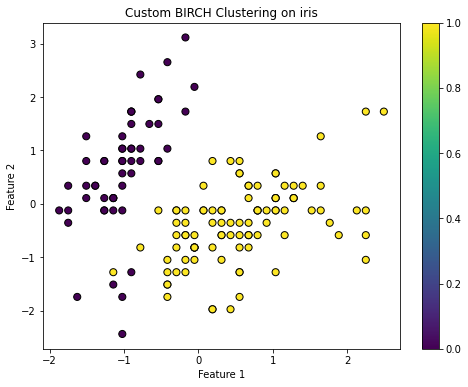

Sklearn BIRCH Labels for iris: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


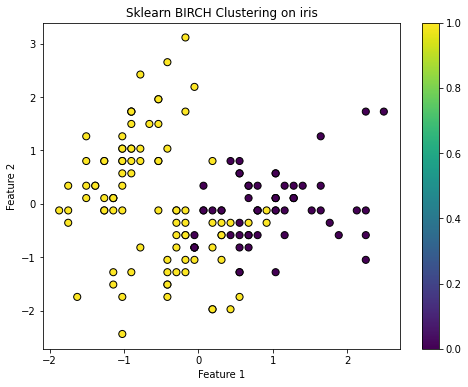


Metrics for iris:
Custom BIRCH Metrics:
Adjusted Rand Index (ARI): 0.1964141113660143
Silhouette Score: 0.5610501299936979
Davies-Bouldin Index: 0.6506105017603327
Calinski-Harabasz Index: 233.64847921628424
Homogeneity: 0.3353432991091101
Completeness: 0.3372624967158322
V-Measure: 0.33630015981574607

Sklearn BIRCH Metrics:
Adjusted Rand Index (ARI): 1.0
Silhouette Score: 0.34412193965947524
Davies-Bouldin Index: 0.9633895971884648
Calinski-Harabasz Index: 110.11497973015699
Homogeneity: 1.0
Completeness: 1.0
V-Measure: 1.0
Dataset: ai_global_index, Type: <class 'pandas.core.frame.DataFrame'>
Custom BIRCH Centroids for ai_global_index:
Cluster 1: [ 0.81790329  0.96355504  0.99778419  1.71288627  1.49354184  1.33248293
  1.42028518  1.6064565  -0.05830929 -0.43852901  0.53417997  0.69651783
 -0.38490018 -0.69006556  0.46626337 -0.29617444  0.60942528  0.25717225
 -0.26937841 -0.32732684]
Cluster 2: [ 5.51273819  1.52171976 -0.11923719  4.8277688   4.42192742  0.74978683
  6.74244485 

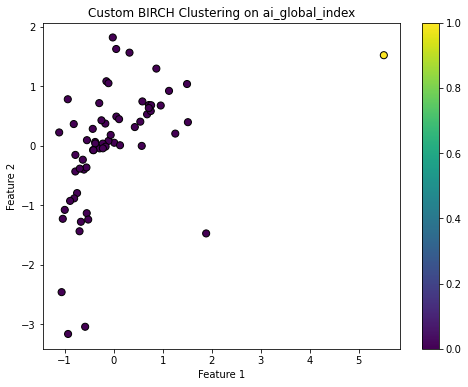

Sklearn BIRCH Labels for ai_global_index: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 1
 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


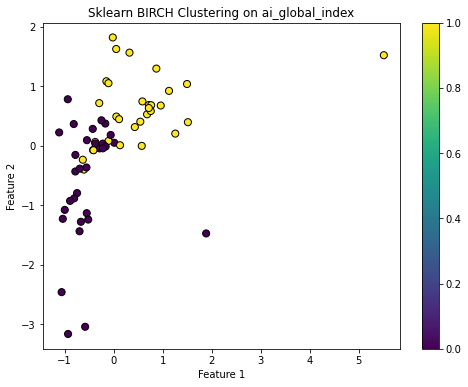


Metrics for ai_global_index:
Custom BIRCH Metrics:
Adjusted Rand Index (ARI): 0.002152635296491877
Silhouette Score: 0.5645056719161807
Davies-Bouldin Index: 0.3120488998125755
Calinski-Harabasz Index: 8.94575677984356
Homogeneity: 0.01710840292737395
Completeness: 0.14352022342893056
V-Measure: 0.030572406255935176

Sklearn BIRCH Metrics:
Adjusted Rand Index (ARI): 1.0
Silhouette Score: 0.19595480058765985
Davies-Bouldin Index: 1.843474706627417
Calinski-Harabasz Index: 14.552205532898403
Homogeneity: 1.0
Completeness: 1.0
V-Measure: 1.0
Dataset: global_earthquake, Type: <class 'pandas.core.frame.DataFrame'>
Custom BIRCH Centroids for global_earthquake:
Cluster 1: [-0.30563237  0.91541472  0.77623639  0.27429128 -0.42111131 -0.3928371
  2.40831892  0.08389311  2.18578744 -0.54481786 -0.75790003 -1.24780845
 -0.1256259   0.59240467 -1.35776422 -1.14697628  0.86842056 -1.23638312]
Cluster 2: [ 1.12567175  1.1465824   0.8384723  -0.17717986  0.68025673 -0.3928371
 -0.4152274   1.4437814

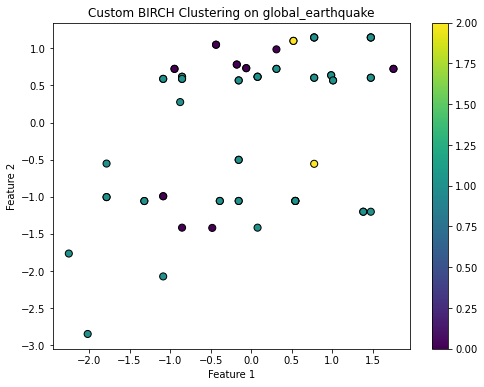

Sklearn BIRCH Labels for global_earthquake: [1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0]


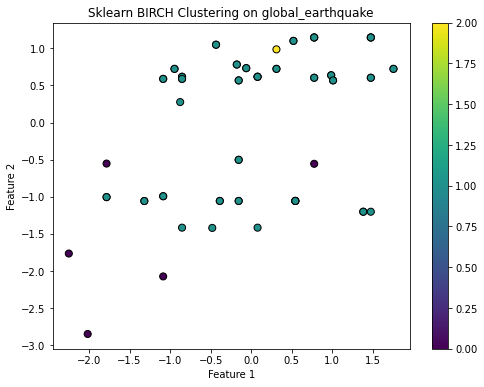


Metrics for global_earthquake:
Custom BIRCH Metrics:
Adjusted Rand Index (ARI): 0.040836264335667984
Silhouette Score: 0.19038440645016966
Davies-Bouldin Index: 1.845943249364433
Calinski-Harabasz Index: 8.104089426098218
Homogeneity: 0.15110843333628213
Completeness: 0.07329951843059396
V-Measure: 0.09871464274899992

Sklearn BIRCH Metrics:
Adjusted Rand Index (ARI): 1.0
Silhouette Score: 0.4008231526730751
Davies-Bouldin Index: 1.0322344073637502
Calinski-Harabasz Index: 10.556482786741343
Homogeneity: 1.0
Completeness: 1.0
V-Measure: 1.0


In [9]:
best_parameters = {
    'iris': {'threshold': 2.0, 'branching_factor': 5, 'n_clusters': 2},
    'ai_global_index': {'threshold': 0.01, 'branching_factor': 5, 'n_clusters': 2},
    'global_earthquake': {'threshold': 2.0, 'branching_factor': 5, 'n_clusters': 3},
}

# Make sure the directory exists for saving the images
os.makedirs('./../results/images', exist_ok=True)

def visualize_clusters(X, labels, title, saveAs=None):
    """
    Function to visualize clustering results.
    Arguments:
        X: Data (features) for the dataset.
        labels: The labels predicted by the clustering algorithm.
        title: Title for the plot.
        saveAs: File name to save the plot (optional).
    """
    plt.figure(figsize=(8, 6))

    # Plot the data points, colored by the cluster labels
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', s=50, edgecolor='k')
    
    # Add a colorbar to show which label corresponds to which color
    plt.colorbar(scatter)
    
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Optionally save the plot
    if saveAs:
        plt.savefig(saveAs)  # Save the image
    plt.show()  # Show the plot interactively

    
# Add visualizations after clustering
def compare_birch_implementations(datasets, best_parameters):
    results = {}

    for name, df in datasets.items():
        print(f"Dataset: {name}, Type: {type(df)}")

        df = df.dropna()

        # Extract numerical features
        X = df.select_dtypes(include=[np.number]).values

        # Normalize the data
        X = StandardScaler().fit_transform(X)

        # Get the best parameters for this dataset
        threshold = best_parameters[name]['threshold']
        branching_factor = best_parameters[name]['branching_factor']
        n_clusters = best_parameters[name]['n_clusters']

        # Run the custom BIRCH implementation
        cf_tree, custom_centroids = birch_clustering(X, threshold, branching_factor, n_clusters)
        custom_labels = np.zeros(len(X))  # Placeholder for custom labels
        # Assign labels based on closest centroid (if needed)
        for i, point in enumerate(X):
            distances = [euclidean(point, centroid) for centroid in custom_centroids]
            custom_labels[i] = np.argmin(distances)

        print(f"Custom BIRCH Centroids for {name}:")
        for i, centroid in enumerate(custom_centroids):
            print(f"Cluster {i + 1}: {centroid}")
        print(f"\nCustom BIRCH Labels for {name}: {custom_labels}")

        # Save and visualize custom BIRCH clusters
        visualize_clusters(X, custom_labels, title=f"Custom BIRCH Clustering on {name}", 
                           saveAs=f"./../results/images/{name}_birch_custom.png")

        # Run the sklearn BIRCH implementation
        sklearn_birch = SklearnBIRCH(threshold=threshold, branching_factor=branching_factor, n_clusters=n_clusters)
        sklearn_labels = sklearn_birch.fit_predict(X)

        print(f"Sklearn BIRCH Labels for {name}: {sklearn_labels}")

        # Save and visualize sklearn BIRCH clusters
        visualize_clusters(X, sklearn_labels, title=f"Sklearn BIRCH Clustering on {name}", 
                           saveAs=f"./../results/images/{name}_birch_sklearn.png")

        # Evaluate clustering using multiple metrics for CUSTOM BIRCH
        custom_metrics = {
            "Adjusted Rand Index (ARI)": adjusted_rand_score(custom_labels, sklearn_labels),
            "Silhouette Score": silhouette_score(X, custom_labels),
            "Davies-Bouldin Index": davies_bouldin_score(X, custom_labels),
            "Calinski-Harabasz Index": calinski_harabasz_score(X, custom_labels),
            "Homogeneity": homogeneity_score(sklearn_labels, custom_labels),
            "Completeness": completeness_score(sklearn_labels, custom_labels),
            "V-Measure": v_measure_score(sklearn_labels, custom_labels),
        }

        # Evaluate clustering using multiple metrics for SKLEARN BIRCH
        sklearn_metrics = {
            "Adjusted Rand Index (ARI)": adjusted_rand_score(sklearn_labels, sklearn_labels),
            "Silhouette Score": silhouette_score(X, sklearn_labels),
            "Davies-Bouldin Index": davies_bouldin_score(X, sklearn_labels),
            "Calinski-Harabasz Index": calinski_harabasz_score(X, sklearn_labels),
            "Homogeneity": homogeneity_score(sklearn_labels, sklearn_labels),
            "Completeness": completeness_score(sklearn_labels, sklearn_labels),
            "V-Measure": v_measure_score(sklearn_labels, sklearn_labels),
        }

        # Store results for both implementations
        results[name] = {
            "Custom BIRCH": custom_metrics,
            "Sklearn BIRCH": sklearn_metrics,
        }

        # Print metrics for both implementations
        print(f"\nMetrics for {name}:")
        print("Custom BIRCH Metrics:")
        for metric_name, value in custom_metrics.items():
            print(f"{metric_name}: {value}")

        print("\nSklearn BIRCH Metrics:")
        for metric_name, value in sklearn_metrics.items():
            print(f"{metric_name}: {value}")

    # Store results in a structured format
    results_df = pd.DataFrame.from_dict({(i, j): results[i][j] 
                                        for i in results.keys() 
                                        for j in results[i].keys()}, 
                                       orient='index')
    results_df.to_csv("./../results/birch_comparison_metrics.csv")

    return results


# Example Usage
if __name__ == "__main__":
    
    # Compare custom BIRCH and Sklearn BIRCH
    results = compare_birch_implementations(datasets, best_parameters)
